# Main file for running our model

In [1]:
###Libraries (not in function files)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse

In [2]:
###Own functions
from project_dataload import data_load, check_data, summarize_1
from project_gaussian import *
from Fingerprints import Sinemats, Coulombmatrices, Ewaldsummatrices
from PCA_decomposition import *
from GP import GP
from SOAP import SOAPfingerprints

In [3]:
###Data load and check

data_dir="./project_data/"
train, test = data_load(data_dir)

print('Check train data')
check_data(train)
print('Check test data')
check_data(test)
summary = summarize_1(train, test)
print('Max number of atoms',summary['max_number_of_atoms'])


Check train data
Train data shape: (8000, 4)
     id        formula                                              atoms  \
0  5154         Zr2BO2  (Atom('Zr', [np.float64(1.6878604657), np.floa...   
1   984          Ni2S6  (Atom('Ni', [np.float64(1.1571403137), np.floa...   
2  1634  Cd4K2Cl6O6Te2  (Atom('Cd', [np.float64(2.7840261751), np.floa...   
3  1872      Hf4H2N3O2  (Atom('Hf', [np.float64(0.0), np.float64(1.867...   
4  2977         Sc2Te2  (Atom('Te', [np.float64(0.0003850118), np.floa...   

      hform  
0 -2.037877  
1 -0.091020  
2 -1.109751  
3 -1.609142  
4 -0.854593  
Check test data
Train data shape: (4000, 3)
      id     formula                                              atoms
0   8538    HfZrSTe2  (Atom('S', [np.float64(-1.0327079693), np.floa...
1   9052    Nb2P2Te6  (Atom('Nb', [np.float64(0.3517632032), np.floa...
2  10503  Au2InI2Se2  (Atom('Se', [np.float64(0.2238411856), np.floa...
3    611   AuTlO6Sb2  (Atom('Au', [np.float64(0.0002076097), np.floa...
4   

In [4]:
### Implement fingerprint
max_num_atoms = summary['max_number_of_atoms']
cmats = Coulombmatrices(train, max_num_atoms)
y_vals = train['hform']
print('Shape of cmats', cmats.shape)

0
1000
2000
3000
4000
5000
6000
7000
Shape of cmats (8000, 400)


In [5]:
# Set target and feature vector 
X = pd.DataFrame(data = cmats, index=train.id)
y = pd.DataFrame(train['hform'].values, index = train.id)
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (8000, 400)
y: (8000, 1)


In [6]:
# Split training data into a training set and a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=251)
y_test_values = y_test.values  # Extract values as a NumPy array
y_train_values = y_train.values  # Extract values as a NumPy array

Shape of split data:  (6400, 400) (1600, 400) (6400, 1) (1600, 1)


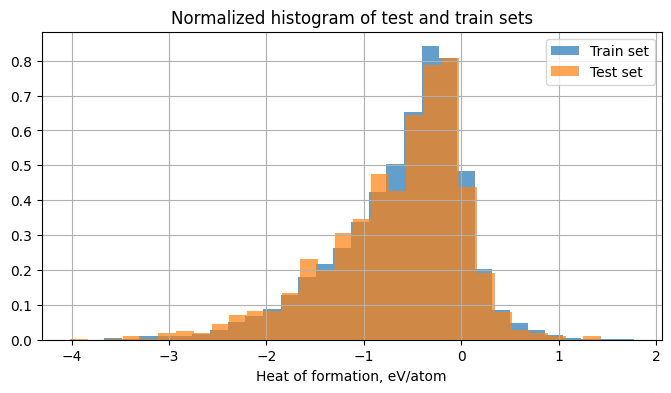

In [7]:
### Split data
print('Shape of split data: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plt.figure(figsize = (8, 4))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.grid()
plt.title("Normalized histogram of test and train sets")
plt.xlabel("Heat of formation, eV/atom")
plt.legend()
plt.show()


In [8]:
# PC Decomposition

n_PC = 50

X_train_pca, X_test_pca = PCA_decomposition(X_train, X_test, n_PC)

With 50 PCA components 93.4117% of the variance is explained
X_train_pca: (6400, 50)
X_test_pca: (1600, 50)


In [9]:
# Gaussian process

simpleGP = GP(X_train_pca, y_train_values, sigma = 0.01)

In [10]:
# Train and predict
k = 1
l=0.04
simpleGP.train_GP(l, k)
predictions = np.array([simpleGP.predict(fingerprint) for fingerprint in X_test_pca])
print(f"With l = {l} RMSE = {rmse(y_test_values, predictions)}")


With l = 0.04 RMSE = 0.6817029819007596


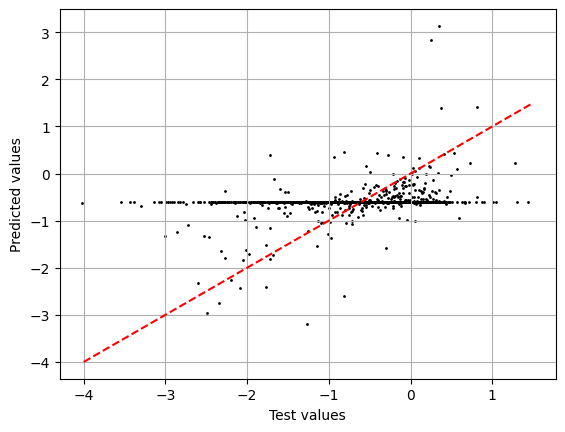

In [11]:
plt.figure()
plt.scatter(y_test_values, predictions, s = 1,color='black')
plt.xlabel('Test values')
plt.ylabel('Predicted values')
plt.grid()
xg = np.linspace(-4,1.5, 2)
plt.plot(xg,xg, color = 'red', linestyle = 'dashed')
